# Tracks Genre Classification

- What does each playlist set sound like? What are their defining characteristics?

- Using user-marked playlist genres as training data, can we build a model to correctly classify songs from a separate track dataset?

In [113]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Read the training data

In [114]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["R&B", "Classical", "Country", "Electronic","Jazz", "Pop", "Rock", "Rap", "Folk pop"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword

    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    track_df_list.append(tdf)
        
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


In [115]:
#check shape
playlist_df.shape, tracks_df.shape

((713, 7), (16356, 22))

In [116]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'playlist_name' 'genre']


In [117]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [118]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(16356, 22)

In [119]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

14099

In [120]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(14099, 22)

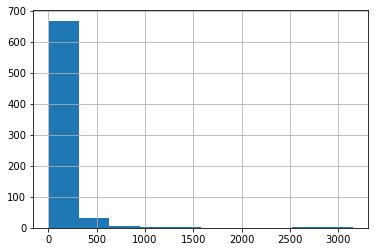

In [121]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

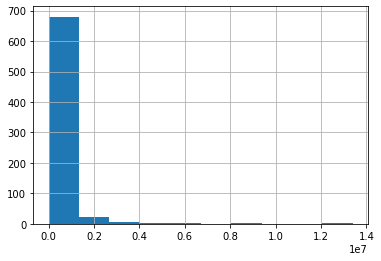

In [122]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [123]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

electronic    0.214838
classical     0.166040
rock          0.136393
jazz          0.111710
rnb           0.105894
pop           0.101071
country       0.088942
rap           0.070998
folk pop      0.004114
Name: genre, dtype: float64

## 2. Refine the training data

In [124]:
#get top playlists
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3186018,rnb
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2386964,rnb
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2030733,rnb
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,860678,rnb
4,37i9dQZF1DXbirtHQBuwCo,TrenChill K-R&B,50,spotify,Spotify,481187,rnb


In [125]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz          690
classical     476
pop           475
rock          461
electronic    375
rnb           281
country       259
rap           229
folk pop       58
Name: genre, dtype: int64

## 3. Feature Engineering

##### Conversions/Normalizations

In [126]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [127]:
#Normalize loudness
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    3304.000000
mean        0.775987
std         0.154225
min         0.000000
25%         0.715724
50%         0.828298
75%         0.882508
max         1.000000
Name: loudness, dtype: float64

In [128]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    3304.000000
mean        0.527479
std         0.135740
min         0.000000
25%         0.415540
50%         0.527032
75%         0.609129
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [129]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
playlist_name         object
genre               category
duration_mins        float64
dtype: object

In [130]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,duration_mins,genre_id
0,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,55,0.608,0.760,...,0.0129,0.0,0.3320,0.366,0.770222,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.194000,7
1,7FWuzwapuKHTEyDJIcQOw3,Stutter (feat. Mystikal) - Double Take Remix,3zTOe1BtyTkwNvYZOxXktX,Joe,6zuCJaxmHKNKN5hMDF556U,213026,2000-04-18,55,0.767,0.759,...,0.0513,0.0,0.3100,0.677,0.412051,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,3.550433,7
2,3QE7ObGjkt1kYnhLvZPRUy,Go On Girl,21E3waRsmPlU7jZsS13rcj,Ne-Yo,52q9xNv8COtSU9phlbO5sg,261426,2007-01-01,65,0.637,0.521,...,0.1550,0.0,0.0945,0.562,0.384152,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.357100,7
3,6De63WRULDaa1fxOyLilnv,Stingy,7r8RF1tN2A4CiGEplkp1oP,Ginuwine,3t4OgAvvOzvXw8D2NHUeDR,259493,2003-04-08,54,0.622,0.573,...,0.2600,0.0,0.1730,0.617,0.582125,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,4.324883,7
4,08fhbfRSg7eEH0IZT7pB6a,That Girl,1goOx6gnQdUllLfSMsL4Rt,Marques Houston,4sAouJxcSwPIoT5dd6Qgj7,215960,2003-10-21,53,0.683,0.552,...,0.5480,0.0,0.2210,0.519,0.453064,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,rnb,3.599333,7


In [131]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{7: 'rnb',
 0: 'classical',
 1: 'country',
 2: 'electronic',
 4: 'jazz',
 5: 'pop',
 8: 'rock',
 6: 'rap',
 3: 'folk pop'}

## 4. Train a KNN model

In [132]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report

In [133]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


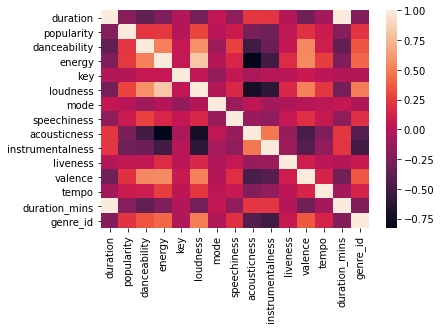

In [134]:
import seaborn as sns

corr = tracks_df.corr()
sns.heatmap(corr)

Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(2643, 8)
Shape of y_Train:(2643,)
Shape of X_Test:(661, 8)
Shape of y_Test:(661,)
Finding best k...


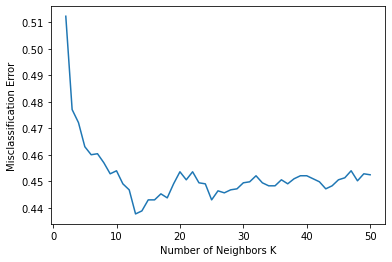

The optimal number of neighbors is 13 with score 56%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(2643, 8)
Shape of y_Train:(2643,)
Shape of X_Test:(661, 8)
Shape of y_Test:(661,)
Finding best k...


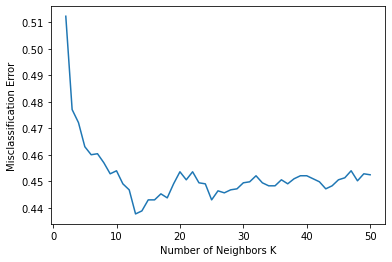

The optimal number of neighbors is 13 with score 56%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(2643, 8)
Shape of y_Train:(2643,)
Shape of X_Test:(661, 8)
Shape of y_Test:(661,)
Finding best k...


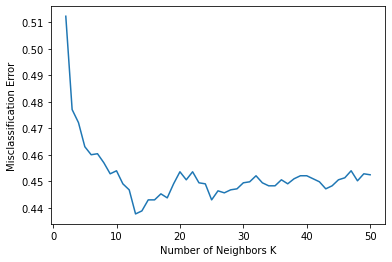

The optimal number of neighbors is 13 with score 56%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(2643, 8)
Shape of y_Train:(2643,)
Shape of X_Test:(661, 8)
Shape of y_Test:(661,)
Finding best k...


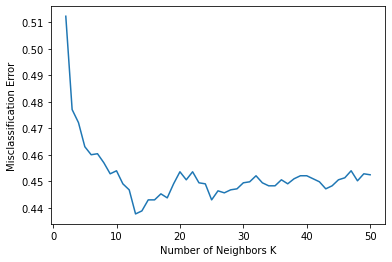

The optimal number of neighbors is 13 with score 56%


In [148]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [149]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[13, 13, 13, 13]

## 5. Model Prediction

In [150]:
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0ofbQMrRDsUaVKq2mGLEAb,Havana,4nDoRrQiYLoBzwC5BhVJzF,Camila Cabello,5chBPOVY2I0bG5V3igb5QL,216896,2017-08-03,4,0.768,0.517,7,-4.323,0,0.0312,0.18600,0.000038,0.1040,0.418,104.992
1,0tgVpDi06FyKpA1z0VMD4v,Perfect,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,263400,2017-03-03,86,0.599,0.448,8,-6.312,1,0.0232,0.16300,0.000000,0.1060,0.168,95.050
2,3hBBKuWJfxlIlnd9QFoC8k,What Lovers Do (feat. SZA),04gDigrS5kc9YWfZHwBETP,Maroon 5,1Jmq5HEJeA9kNi2SgQul4U,199849,2017-11-03,4,0.795,0.615,5,-5.211,0,0.0671,0.07860,0.000003,0.0855,0.393,110.009
3,1mXVgsBdtIVeCLJnSnmtdV,Too Good At Goodbyes,2wY79sveU1sp5g7SokKOiI,Sam Smith,3TJz2UBNYJtlEly0sPeNrQ,201000,2017-11-03,81,0.681,0.372,5,-8.237,1,0.0432,0.64000,0.000000,0.1690,0.476,91.873
4,2ekn2ttSfGqwhhate0LSR0,New Rules,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,01sfgrNbnnPUEyz6GZYlt9,209320,2017-06-02,80,0.762,0.700,9,-6.021,0,0.0694,0.00261,0.000016,0.1530,0.608,116.073


In [151]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [152]:
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 13


In [153]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk pop_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
1165,2HO0uCyq8jOveEzvmo4JEu,Fly,64KEffDW9EtZ1y2vBYgq8T,Marshmello,3HuhZO6x7i7vXqjQfOEh7b,193777,2018-03-09,64,0.630,0.900,...,1.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1697,2mlGPkAx4kwF8Df0GlScsC,Buttercup,1vVHevk2PD45epYnDi9CCc,Jack Stauber,1RHa1VdX6lsLbeedgsV1cb,208026,2017-03-25,80,0.705,0.373,...,1.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
2119,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,51,0.304,0.154,...,1.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
141,4VuS959DSpr82t3qBqCrWG,Supermarket Flowers,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,221106,2017-03-03,77,0.589,0.242,...,0.923077,0.0,0.000000,0.0,0.076923,0.923077,0.0,0.0,0.0,0.000000
1098,3PIDciSFdrQxSQSihim3hN,Christmas (Baby Please Come Home),4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,61ulfFSmmxMhc2wCdmdMkN,153240,1994-11-01,61,0.566,0.782,...,0.923077,0.0,0.076923,0.0,0.000000,0.000000,0.0,0.0,0.0,0.923077


Check out tracks with highest assigned probability

In [154]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
1165,Marshmello,Fly,electronic,1.000000
1697,Jack Stauber,Buttercup,jazz,1.000000
2119,HONNE,dear P,classical,1.000000
141,Ed Sheeran,Supermarket Flowers,jazz,0.923077
1098,Mariah Carey,Christmas (Baby Please Come Home),rock,0.923077
342,Charice,Sometimes Love Just Ain't Enough,jazz,0.846154
158,Howie Day,Collide - Acoustic Version,jazz,0.846154
384,Moira Dela Torre,Take Her to the Moon,jazz,0.846154
575,Eraserheads,Ligaya,rock,0.846154
357,BlocBoy JB,Look Alive (feat. Drake),rap,0.846154


View histogram of predicted genre probabilities

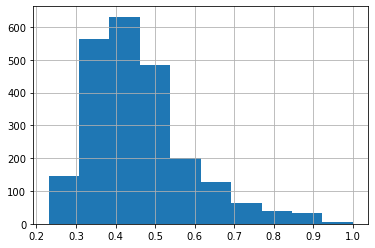

In [155]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [165]:
chart_tracks_df['predicted_genre'].value_counts()

pop           593
rock          503
jazz          351
country       323
rap           214
rnb           195
electronic     80
classical      22
folk pop       11
Name: predicted_genre, dtype: int64

In [166]:
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk pop_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
1165,2HO0uCyq8jOveEzvmo4JEu,Fly,64KEffDW9EtZ1y2vBYgq8T,Marshmello,3HuhZO6x7i7vXqjQfOEh7b,193777,2018-03-09,64,0.630,0.900,...,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1697,2mlGPkAx4kwF8Df0GlScsC,Buttercup,1vVHevk2PD45epYnDi9CCc,Jack Stauber,1RHa1VdX6lsLbeedgsV1cb,208026,2017-03-25,80,0.705,0.373,...,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2119,61lfBHo44YaBIhAx1031CP,dear P,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,61426,2020-07-03,51,0.304,0.154,...,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
141,4VuS959DSpr82t3qBqCrWG,Supermarket Flowers,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,221106,2017-03-03,77,0.589,0.242,...,0.923077,0.0,0.000000,0.000000,0.076923,0.923077,0.000000,0.000000,0.000000,0.000000
1098,3PIDciSFdrQxSQSihim3hN,Christmas (Baby Please Come Home),4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,61ulfFSmmxMhc2wCdmdMkN,153240,1994-11-01,61,0.566,0.782,...,0.923077,0.0,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,2wVDWtLKXunswWecARNILj,SOLO,250b0Wlc5Vk0CoUsaCY84M,JENNIE,7qAJpYeABXN9ZV5wOOX59k,169566,2018-11-12,73,0.751,0.642,...,0.230769,0.0,0.230769,0.076923,0.000000,0.000000,0.076923,0.230769,0.230769,0.153846
605,6Bg7MznA9X0dIhlAsLyBYj,Ghost Town,5K4W6rqBFWDnAN6FQUkS6x,Kanye West,5EBGCvO6upi3GNknMVe9x9,271386,2018-06-01,1,0.572,0.543,...,0.230769,0.0,0.230769,0.000000,0.000000,0.153846,0.230769,0.076923,0.076923,0.230769
2152,1Z0sOoWABNbbiadSEea2z9,I,5GoU6Zkbt3w10nTYq6vBQh,Twenty Nine Eleven,5adFklVMUam3oGM6vULmuo,204816,2020-06-19,60,0.522,0.327,...,0.230769,0.0,0.153846,0.000000,0.076923,0.230769,0.230769,0.000000,0.076923,0.230769
964,2rbDhOo9Fh61Bbu23T2qCk,Always Remember Us This Way,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,3edjzMAVB9RYRd4UcZBchx,210200,2018-10-05,78,0.553,0.502,...,0.230769,0.0,0.153846,0.000000,0.000000,0.153846,0.230769,0.076923,0.230769,0.153846


>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [167]:
chart_tracks_df[chart_tracks_df['track_name']=='Always Remember Us This Way']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_folk pop_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
941,74iZuPGwyL33VlTr6jTnab,Always Remember Us This Way,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,4sLtOBOzn4s3GDUv3c5oJD,210200,2018-10-05,74,0.553,0.502,...,0.230769,0.0,0.153846,0.0,0.0,0.153846,0.230769,0.076923,0.230769,0.153846
964,2rbDhOo9Fh61Bbu23T2qCk,Always Remember Us This Way,1HY2Jd0NmPuamShAr6KMms,Lady Gaga,3edjzMAVB9RYRd4UcZBchx,210200,2018-10-05,78,0.553,0.502,...,0.230769,0.0,0.153846,0.0,0.0,0.153846,0.230769,0.076923,0.230769,0.153846


In [158]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Caveats
1. Using playlist names as genre tags heavily rely on *user opinion* and not *extracted music features* (compare this from the methods used in the [GTZAN genre collection dataset](https://data-flair.training/blogs/python-project-music-genre-classification/)
2. Playlists with dual genre names exists, and appear quite often in the dataset (e.g. Electronic Pop, Classical Rock)
3. Although a dominant genre could be readily observed, recent music tend to incorporate many genres at a time and thus create less distinction when the model looks at the audio features.

>Q: What other caveats could you deduce from the steps done above?


## Model Improvement
To enhance the model accuracy, try to do the following:
1. Pick "purer" top-followed playlists for the training data. A quick way to do this is to pick playlists that contain pre 2000's music as majority as these are less hybridized than more recent songs.
2. Try fewer but broader genres as categories (4-5 genres)
3. Remove outlier songs! These are the songs that dont fit its playlist's description. A bit subjective (and tedious!).
4. Limit the features used as predictors (could be inferred from the list of genres you're considering)


## Day Deliverable
*A. For your individual curiosities*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. For your sprint project*
4. Extract a tracks dataset that is relevant to the client you are targeting. 
   For example:
    - A client artist's full discography
    - Tracks from a popular playlist in spotify that your client artist appears in
    - Discographies of prospect artists to collaborate with 
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   

